# A Deeper Dive Into IPOs

### Introduction
These datasets help us to understanding startup growth trajectories, capital inflows, and exit outcomes in the venture capital (VC) ecosystem. By analyzing these datasets, we can gain critical insights into how startups evolve from early funding stages to public market offerings, and how investor behaviors and market trends shape these outcomes. With both datasets, we can track the path from startup to IPO, compare across industries, geography, and funding stages, identify high performing investors, and understand how funding patterns influence exti options. This data is specifically for VC Firms, startup founders, private equity firms, and researchers and analysts (provide empirical studies on startups). Performance metrics such as capital efficiency, exit likelihood, and funding trajectory are all extremely relevant to interested parties. We decided to look at these datasets because we were curious to learn more about startups. The University of Chicago has a wide range of startups being launched and we wanted to know what the trajectory usually looks like for them.

### Background

In [2]:
import pandas as pd

In [3]:
ipo_df = pd.read_csv('ipos.csv')
fr_df = pd.read_csv('funding_rounds.csv')

In [4]:
ipo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1259 non-null   int64  
 1   ipo_id                   1259 non-null   int64  
 2   object_id                1254 non-null   object 
 3   valuation_amount         1259 non-null   float64
 4   valuation_currency_code  1257 non-null   object 
 5   raised_amount            1259 non-null   float64
 6   raised_currency_code     699 non-null    object 
 7   public_at                659 non-null    object 
 8   stock_symbol             1259 non-null   object 
 9   source_url               191 non-null    object 
 10  source_description       180 non-null    object 
 11  created_at               1259 non-null   object 
 12  updated_at               1259 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 128.0+ KB


In [5]:
fr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52928 entries, 0 to 52927
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        52928 non-null  int64  
 1   funding_round_id          52928 non-null  int64  
 2   object_id                 52928 non-null  object 
 3   funded_at                 52680 non-null  object 
 4   funding_round_type        52928 non-null  object 
 5   funding_round_code        52928 non-null  object 
 6   raised_amount_usd         52928 non-null  float64
 7   raised_amount             52928 non-null  float64
 8   raised_currency_code      49862 non-null  object 
 9   pre_money_valuation_usd   52928 non-null  float64
 10  pre_money_valuation       52928 non-null  float64
 11  pre_money_currency_code   26883 non-null  object 
 12  post_money_valuation_usd  52928 non-null  float64
 13  post_money_valuation      52928 non-null  float64
 14  post_m

### Data Cleansing

In [6]:
# First, create the IPO label column
ipo_df['went_ipo'] = 1  # Mark IPO companies

# Merge: left join from funding to IPO to label companies
merged_df = fr_df.merge(
    ipo_df[['object_id', 'went_ipo']],
    on='object_id',
    how='left'
)

# Fill NaN with 0 → companies that didn't IPO
merged_df['went_ipo'] = merged_df['went_ipo'].fillna(0).astype(int)

In [7]:
# Now lets check data types in order to aggregate data by company

print(merged_df.dtypes)

id                            int64
funding_round_id              int64
object_id                    object
funded_at                    object
funding_round_type           object
funding_round_code           object
raised_amount_usd           float64
raised_amount               float64
raised_currency_code         object
pre_money_valuation_usd     float64
pre_money_valuation         float64
pre_money_currency_code      object
post_money_valuation_usd    float64
post_money_valuation        float64
post_money_currency_code     object
participants                  int64
is_first_round                int64
is_last_round                 int64
source_url                   object
source_description           object
created_by                   object
created_at                   object
updated_at                   object
went_ipo                      int64
dtype: object


In [8]:
# Grouping and aggregating per startup (object_id)
company_agg = merged_df.groupby('object_id').agg({
    'funding_round_id': 'count',                       # total funding rounds
    'raised_amount_usd': ['sum', 'mean', 'max'],       # investment stats
    'participants': ['sum', 'mean', 'max'],            # participant stats
    'is_first_round': 'sum',                           # how often it was the first round
    'is_last_round': 'sum',                            # how often it was the last round
    'went_ipo': 'max'                                  # target variable (still per company)
})

# Flatten multi-level columns
company_agg.columns = ['_'.join(col).strip() for col in company_agg.columns.values]

# Reset index so object_id becomes a column again
company_agg = company_agg.reset_index()

# Preview result
company_agg.head()

,object_id,funding_round_id_count,raised_amount_usd_sum,raised_amount_usd_mean,raised_amount_usd_max,participants_sum,participants_mean,participants_max,is_first_round_sum,is_last_round_sum,went_ipo_max
0,c:1,3,39750000.0,1.325000e+07,25000000.0,9,3.000000,4,1,1,0
1,c:1001,1,5000000.0,5.000000e+06,5000000.0,3,3.000000,3,1,1,0
2,c:10014,1,0.0,0.000000e+00,0.0,1,1.000000,1,1,1,0
3,c:10015,5,68069200.0,1.361384e+07,43000000.0,19,3.800000,5,1,1,0
4,c:100155,3,10125293.0,3.375098e+06,6500000.0,5,1.666667,3,1,1,0


In [9]:
company_agg['went_ipo_max'].value_counts()

went_ipo_max
0    31415
1      524
Name: count, dtype: int64

In [10]:
# Checking for missing values
missing_values = company_agg.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(company_agg)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing %': missing_percentage})
print(missing_df)

                        Missing Count  Missing %
object_id                           0        0.0
funding_round_id_count              0        0.0
raised_amount_usd_sum               0        0.0
raised_amount_usd_mean              0        0.0
raised_amount_usd_max               0        0.0
participants_sum                    0        0.0
participants_mean                   0        0.0
participants_max                    0        0.0
is_first_round_sum                  0        0.0
is_last_round_sum                   0        0.0
went_ipo_max                        0        0.0


In [11]:
# Summary stats for key variables

summary_stats = company_agg[['raised_amount_usd_sum', 'participants_sum', 'funding_round_id_count']].describe().T

# Format the output using style
summary_stats.style \
    .format("{:,.2f}") \
    .set_caption("Summary Statistics of Key Company Metrics") \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'black'), ('font-size', '16px'), ('text-align', 'center')]
    }])

,count,mean,std,min,25%,50%,75%,max
raised_amount_usd_sum,"31,939.00","13,170,984.84","67,305,586.21",0.00,"200,000.00","1,700,000.00","9,100,000.00","5,700,000,000.00"
participants_sum,"31,939.00",2.53,4.00,0.00,0.00,1.00,3.00,58.00
funding_round_id_count,"31,939.00",1.66,1.20,1.00,1.00,1.00,2.00,15.00


### Data Analysis

In [12]:
# IPO Outcome Stats Table
ipo_outcome_stats = company_agg.groupby('went_ipo_max')[
    ['raised_amount_usd_sum', 'participants_sum']
].mean().rename(index={0: "Did not IPO", 1: "Went IPO"})

ipo_outcome_stats.style.format("{:,.0f}").set_caption("Average Stats by IPO Outcome")


,raised_amount_usd_sum,participants_sum
went_ipo_max,,
Did not IPO,"11,581,749",3
Went IPO,"108,449,318",4


In [13]:
# Top 10 Companies by Total Raised
top_raised = company_agg[['object_id', 'raised_amount_usd_sum']].sort_values(
    by='raised_amount_usd_sum', ascending=False).head(10)

top_raised.style.format({"raised_amount_usd_sum": "${:,.0f}"}).set_caption("Top 10 Companies by Total Raised")


,object_id,raised_amount_usd_sum
987,c:13219,"$5,700,000,000"
24634,c:4843,"$3,985,050,000"
10179,c:216492,"$3,822,518,000"
13375,c:242735,"$2,600,000,000"
25053,c:5,"$2,425,700,000"
27947,c:64365,"$2,400,000,000"
11198,c:22568,"$1,765,504,319"
27048,c:5951,"$1,451,000,000"
21775,c:39799,"$1,270,283,000"
13911,c:24693,"$1,200,000,000"


In [14]:
# Distribution of Funding Rounds per Company
rounds_distribution = company_agg['funding_round_id_count'].value_counts().sort_index().reset_index()
rounds_distribution.columns = ['Number of Rounds', 'Number of Companies']

rounds_distribution.style.format("{:,}").set_caption("Distribution of Funding Rounds per Company")

,Number of Rounds,Number of Companies
0,1,"20,721"
1,2,"6,171"
2,3,"2,671"
3,4,"1,220"
4,5,603
5,6,249
6,7,147
7,8,67
8,9,46
9,10,23


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

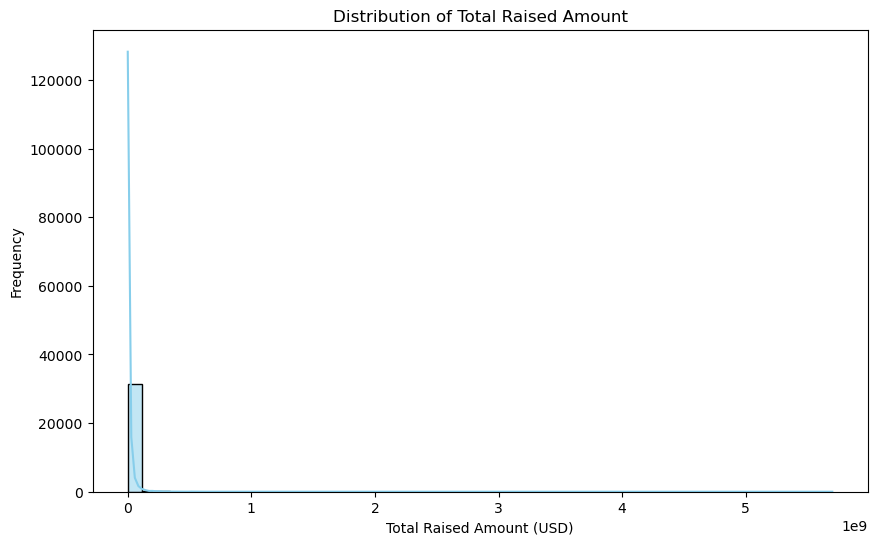

In [16]:
# Distribution of raised amount

plt.figure(figsize=(10,6))
sns.histplot(company_agg['raised_amount_usd_sum'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Total Raised Amount')
plt.xlabel('Total Raised Amount (USD)')
plt.ylabel('Frequency')
plt.show()

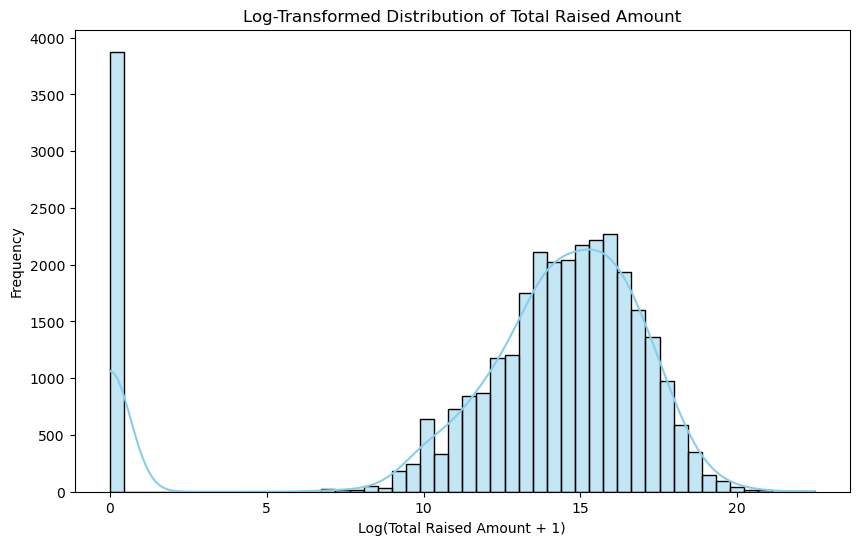

In [17]:
# Log distribution of raised amount

plt.figure(figsize=(10,6))
# Add 1 to avoid log(0)
sns.histplot(np.log1p(company_agg['raised_amount_usd_sum']), bins=50, kde=True, color='skyblue')
plt.title('Log-Transformed Distribution of Total Raised Amount')
plt.xlabel('Log(Total Raised Amount + 1)')
plt.ylabel('Frequency')
plt.show()

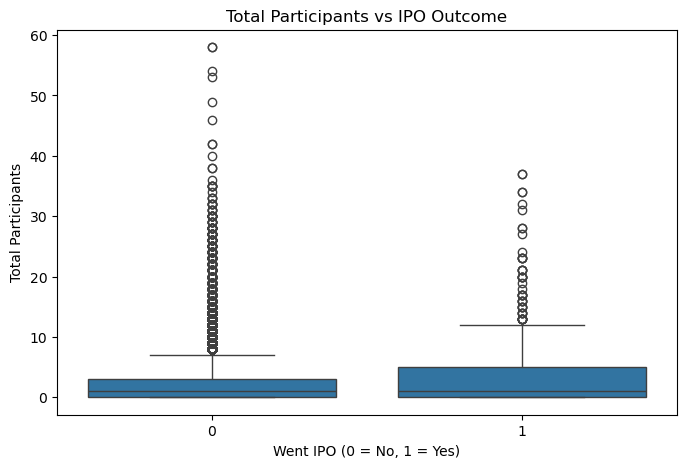

In [18]:
# Boxplot of Participants vs IPO Status
plt.figure(figsize=(8,5))
sns.boxplot(x='went_ipo_max', y='participants_sum', data=company_agg)
plt.title('Total Participants vs IPO Outcome')
plt.xlabel('Went IPO (0 = No, 1 = Yes)')
plt.ylabel('Total Participants')
plt.show()

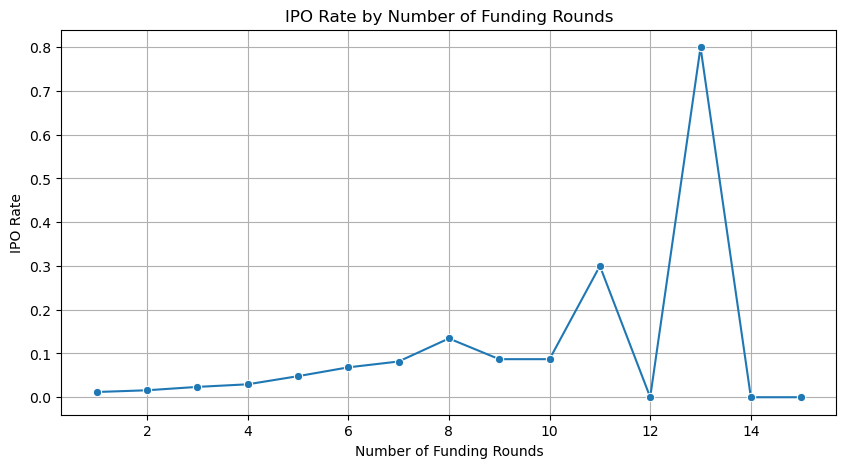

In [19]:
# Funding Rounds Count vs IPO Rate
ipo_by_rounds = (
    company_agg
    .groupby('funding_round_id_count')
    .agg(ipo_rate=('went_ipo_max', 'mean'))
    .reset_index()
    .rename(columns={'funding_round_id_count': 'Funding Rounds', 'ipo_rate': 'IPO Rate'})
)

plt.figure(figsize=(10,5))
sns.lineplot(data=ipo_by_rounds, x='Funding Rounds', y='IPO Rate', marker='o')
plt.title('IPO Rate by Number of Funding Rounds')
plt.ylabel('IPO Rate')
plt.xlabel('Number of Funding Rounds')
plt.grid(True)
plt.show()

In [20]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

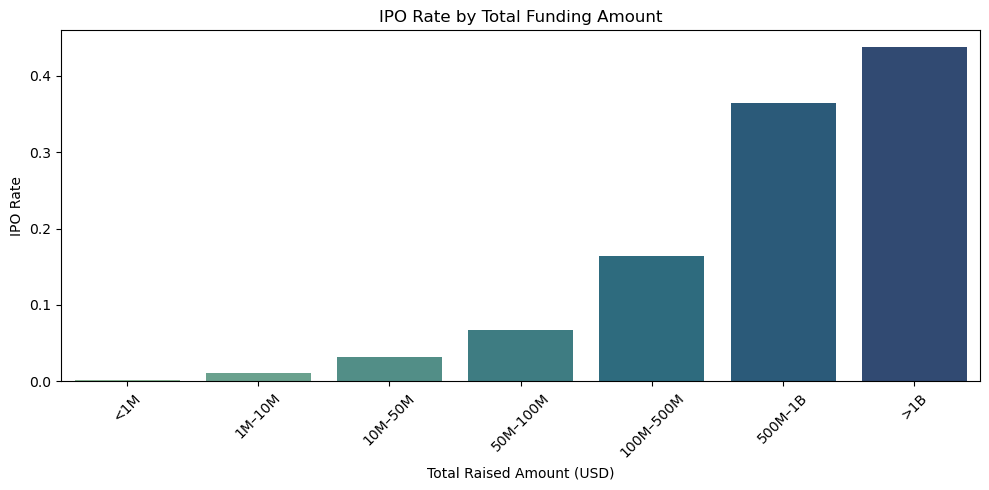

In [21]:
# Funding Raised Bin vs IPO Rate

# Define bins for raised amount (you can adjust bin edges)
bins = [0, 1e6, 1e7, 5e7, 1e8, 5e8, 1e9, company_agg['raised_amount_usd_sum'].max()]
labels = [
    '<1M', '1M–10M', '10M–50M', '50M–100M',
    '100M–500M', '500M–1B', '>1B'
]

# Bin the data
company_agg['raised_amount_bin'] = pd.cut(company_agg['raised_amount_usd_sum'], bins=bins, labels=labels)

# Calculate IPO rate per bin
ipo_by_bin = (
    company_agg.groupby('raised_amount_bin')
    .agg(ipo_rate=('went_ipo_max', 'mean'))
    .reset_index()
    .rename(columns={'ipo_rate': 'IPO Rate'})
)

plt.figure(figsize=(10, 5))
sns.barplot(data=ipo_by_bin, x='raised_amount_bin', y='IPO Rate', palette='crest')
plt.title('IPO Rate by Total Funding Amount')
plt.xlabel('Total Raised Amount (USD)')
plt.ylabel('IPO Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

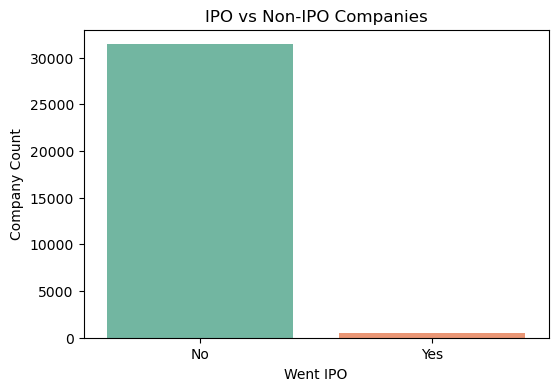

In [22]:
#  IPO vs Non-IPO Counts

plt.figure(figsize=(6,4))
sns.countplot(x='went_ipo_max', data=company_agg, palette='Set2')
plt.title('IPO vs Non-IPO Companies')
plt.xlabel('Went IPO')
plt.ylabel('Company Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

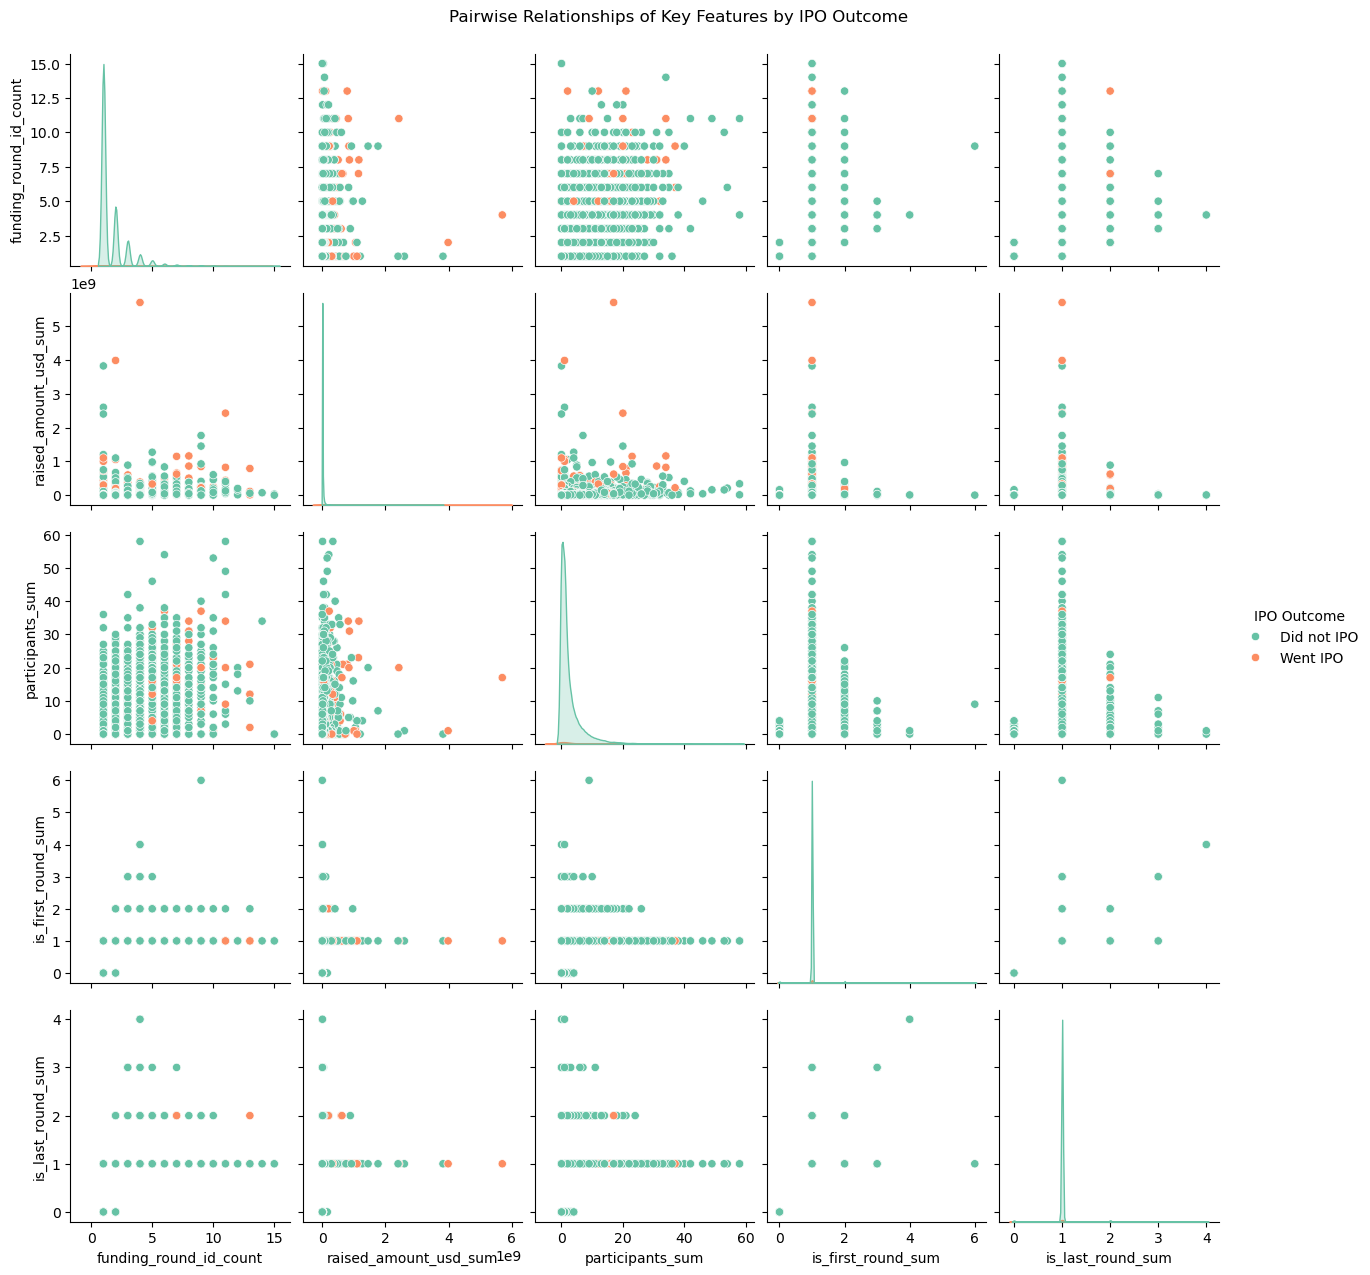

In [23]:
# Pairplot Colored by IPO Outcome

# Select key numeric features
features = [
    'funding_round_id_count',
    'raised_amount_usd_sum',
    'participants_sum',
    'is_first_round_sum',
    'is_last_round_sum',
    'went_ipo_max'
]

# Create a smaller DataFrame
pairplot_data = company_agg[features].copy()
pairplot_data['IPO Outcome'] = pairplot_data['went_ipo_max'].map({0: 'Did not IPO', 1: 'Went IPO'})

# Plot
sns.pairplot(pairplot_data.drop(columns='went_ipo_max'), hue='IPO Outcome', diag_kind='kde', palette='Set2')
plt.suptitle('Pairwise Relationships of Key Features by IPO Outcome', y=1.02)
plt.show()

In [29]:
# Linear regression model

# 1. Preparing the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = company_agg[[
    'raised_amount_usd_sum'
]]

y = company_agg['went_ipo_max']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# 2. Train the logistic regresion model

from sklearn.linear_model import LogisticRegression

# Initialize and train
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [31]:
# 3. Evaluate the model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Predictions
y_pred = logreg.predict(X_test_scaled)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9838760175328741
Precision: 0.75
Recall: 0.02857142857142857
F1 Score: 0.05504587155963303

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6283
           1       0.75      0.03      0.06       105

    accuracy                           0.98      6388
   macro avg       0.87      0.51      0.52      6388
weighted avg       0.98      0.98      0.98      6388



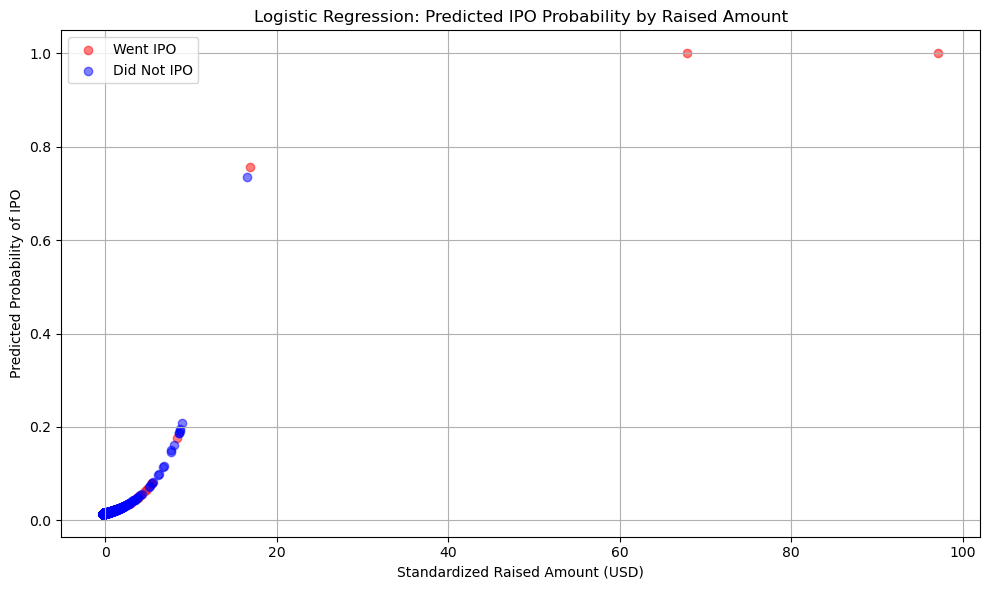

In [32]:
# Predicted probability of IPO (class 1)
prob_prediction = logreg.predict_proba(X_test_scaled)[:, 1]

# Mask for actual IPO vs not
ipo_mask = y_test.values == 1
non_ipo_mask = ~ipo_mask

# Plot
plt.figure(figsize=(10,6))
plt.scatter(X_test_scaled[ipo_mask], prob_prediction[ipo_mask], color='red', label='Went IPO', alpha=0.5)
plt.scatter(X_test_scaled[non_ipo_mask], prob_prediction[non_ipo_mask], color='blue', label='Did Not IPO', alpha=0.5)

plt.xlabel('Standardized Raised Amount (USD)')
plt.ylabel('Predicted Probability of IPO')
plt.title('Logistic Regression: Predicted IPO Probability by Raised Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Confusion Matrix:
[[6282    1]
 [ 102    3]]
ROC AUC Score: 0.837


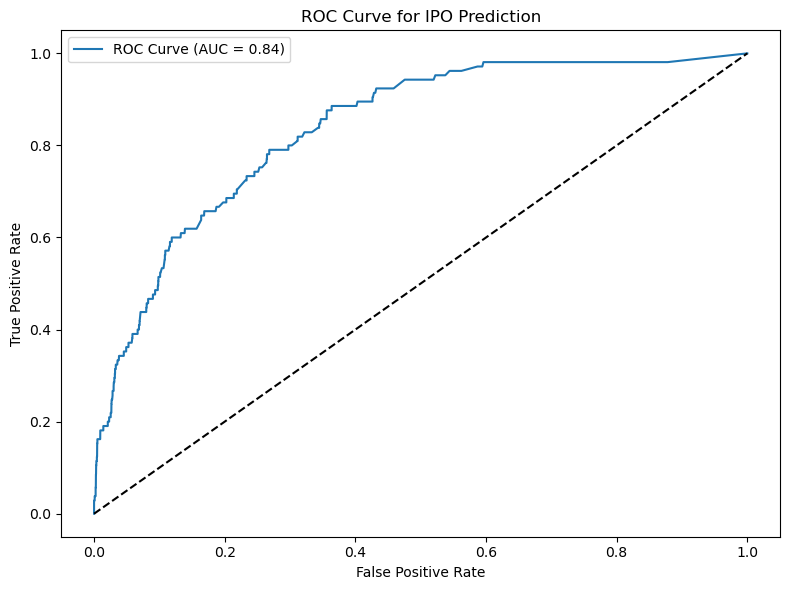

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Predict probabilities for the positive class
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for IPO Prediction")
plt.legend()
plt.tight_layout()
plt.show()